<a href="https://colab.research.google.com/github/cyberone1812/CMUDeepLearning/blob/main/w8_dele_embeddings_encoder_pytorch_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
pip install accelerate -U

In [ ]:
pip install transformers[torch]

#### RNN with `pytorch`

In [ ]:
x = torch.randn(5, 3, 10)

In [ ]:
x

In [ ]:
rnn = nn.RNN(input_size = 10,
             hidden_size = 10,
             num_layers = 1)

In [ ]:
rnn(x)

In [ ]:
outputs, hiddens = rnn(x)

In [ ]:
outputs.shape

In [ ]:
l1 = nn.Linear(in_features = 10,
               out_features = 100)

In [ ]:
x = l1(outputs)

In [ ]:
l2 = nn.Linear(100, 1)

In [ ]:
x = l2(x)

In [ ]:
x

tensor([[[0.1760],
         [0.1889],
         [0.0950]],

        [[0.3071],
         [0.4308],
         [0.3901]],

        [[0.2531],
         [0.1595],
         [0.1043]],

        [[0.2620],
         [0.1357],
         [0.1877]],

        [[0.1738],
         [0.1456],
         [0.1251]]], grad_fn=<ViewBackward0>)

In [ ]:
loss_fn = nn.BCELoss()

In [ ]:
#Tokenize and predict spam emails -- todo!!!

### Autoencoders with `pytorch`

- Build basic autoencoder to reconstruct fashion objects
- Use Convolutional network to build encoder/decoder architecture

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Autoencoder_schema.png/440px-Autoencoder_schema.png)

In [ ]:
#load in training data
train = datasets.FashionMNIST('.', download=True, transform=ToTensor())

In [ ]:
#look at an example
train_iter = iter(train)
next(train_iter)[0].shape

torch.Size([1, 28, 28])

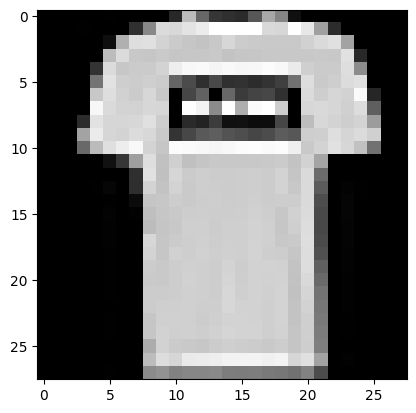

In [ ]:
plt.imshow(next(train_iter)[0].reshape(28, 28), cmap = 'gray')

In [ ]:
#basic encoder
encoder = nn.Sequential(nn.Linear(28*28, 100),
                        nn.ReLU(),
                        nn.Linear(100, 50),
                        nn.ReLU(),
                        nn.Linear(50, 1))

In [ ]:
#basic decoder
decoder = nn.Sequential(nn.Linear(1, 50),
                        nn.ReLU(),
                        nn.Linear(50, 100),
                        nn.ReLU(),
                        nn.Linear(100, 28*28),
                        nn.Sigmoid())

In [ ]:
#pass example through
ex_img = train[0][0].reshape(-1, 28*28)

In [ ]:
sample_im = decoder(encoder(ex_img))

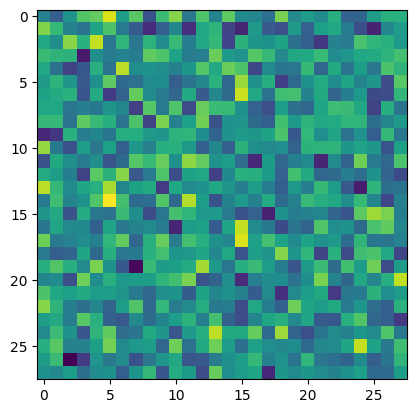

In [ ]:
plt.imshow(sample_im.detach().numpy().reshape(28, 28))

In [ ]:
#autoencoder class
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(nn.Linear(28*28, 100),
                        nn.ReLU(),
                        nn.Linear(100, 50),
                        nn.ReLU(),
                        nn.Linear(50, 4))


    self.decoder = nn.Sequential(nn.Linear(4, 50),
                        nn.ReLU(),
                        nn.Linear(50, 100),
                        nn.ReLU(),
                        nn.Linear(100, 28*28),
                        nn.Sigmoid())

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x


In [ ]:
#model, loss, optimizer
model = AutoEncoder()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
#move to gpu
device = "cuda"
model = model.to(device)

In [ ]:
train_loader = DataLoader(train, batch_size = 32)

In [ ]:
#training loop
outputs = []
for epoch in range(5):
  for img, _ in train_loader:
    img = img.reshape(-1, 28*28)
    img = img.to(device)
    output = model(img)
    loss = loss_fn(output, img)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch: {epoch}, Loss: {loss.item()}')
  outputs.append((output, img))

Epoch: 0, Loss: 0.022873548790812492
Epoch: 1, Loss: 0.020585671067237854
Epoch: 2, Loss: 0.01957150734961033
Epoch: 3, Loss: 0.019054114818572998
Epoch: 4, Loss: 0.018655268475413322


In [ ]:
outputs[0][0].shape

torch.Size([32, 784])

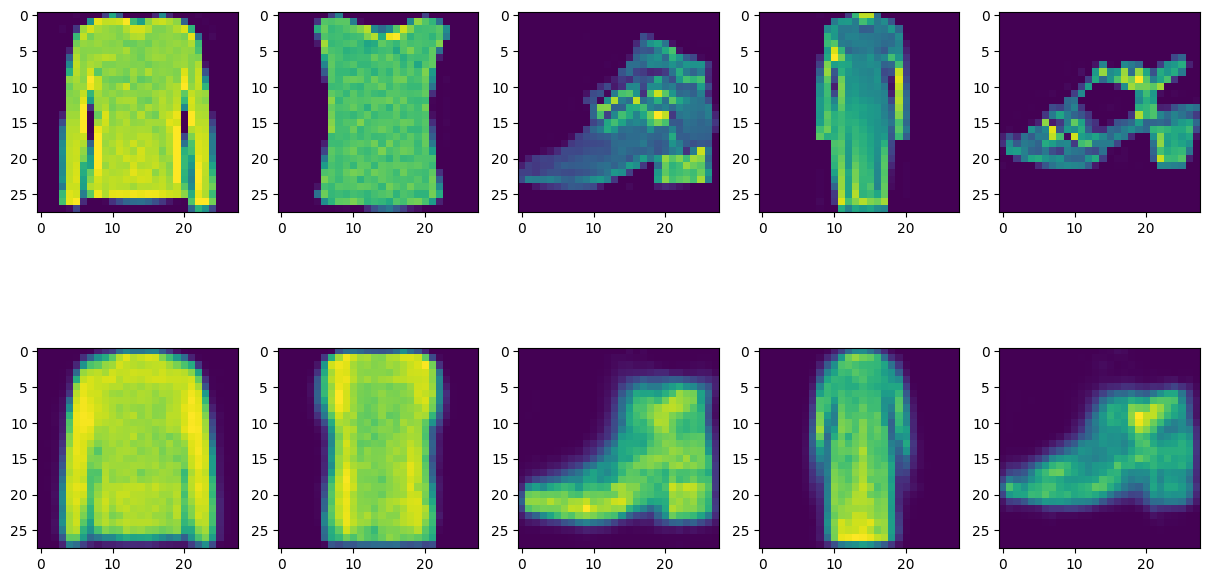

In [ ]:
fig, ax = plt.subplots(2, 5, figsize = (15, 8))
for i in range(5):
  ax[0, i].imshow(outputs[i][1][i].cpu().detach().numpy().reshape(28, 28))
  ax[1, i].imshow(outputs[i][0][i].cpu().detach().numpy().reshape(28, 28))

#### A Convolutional Autoencoder

In [ ]:
class CNNAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, padding = 1), # N, 16, 28, 28
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, padding = 1), # N, 32, 28, 28
        nn.ReLU(),
        nn.Conv2d(32, 64, 7, padding = 1),
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, padding = 1),
        nn.Sigmoid()
    )

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

In [ ]:
model = CNNAutoEncoder()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
model = model.to(device)

In [ ]:
outputs = []
for epoch in range(5):
  for img, label in train_loader:
    img = img.to(device)
    out_im = model(img)
    loss = loss_fn(out_im, img)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch: {epoch}. Loss: {loss.item()}')
  outputs.append((img, out_im))

Epoch: 0. Loss: 0.00044738463475368917
Epoch: 1. Loss: 0.00010571124585112557
Epoch: 2. Loss: 0.0003146065864712
Epoch: 3. Loss: 0.00010693453077692538
Epoch: 4. Loss: 9.705138654680923e-05


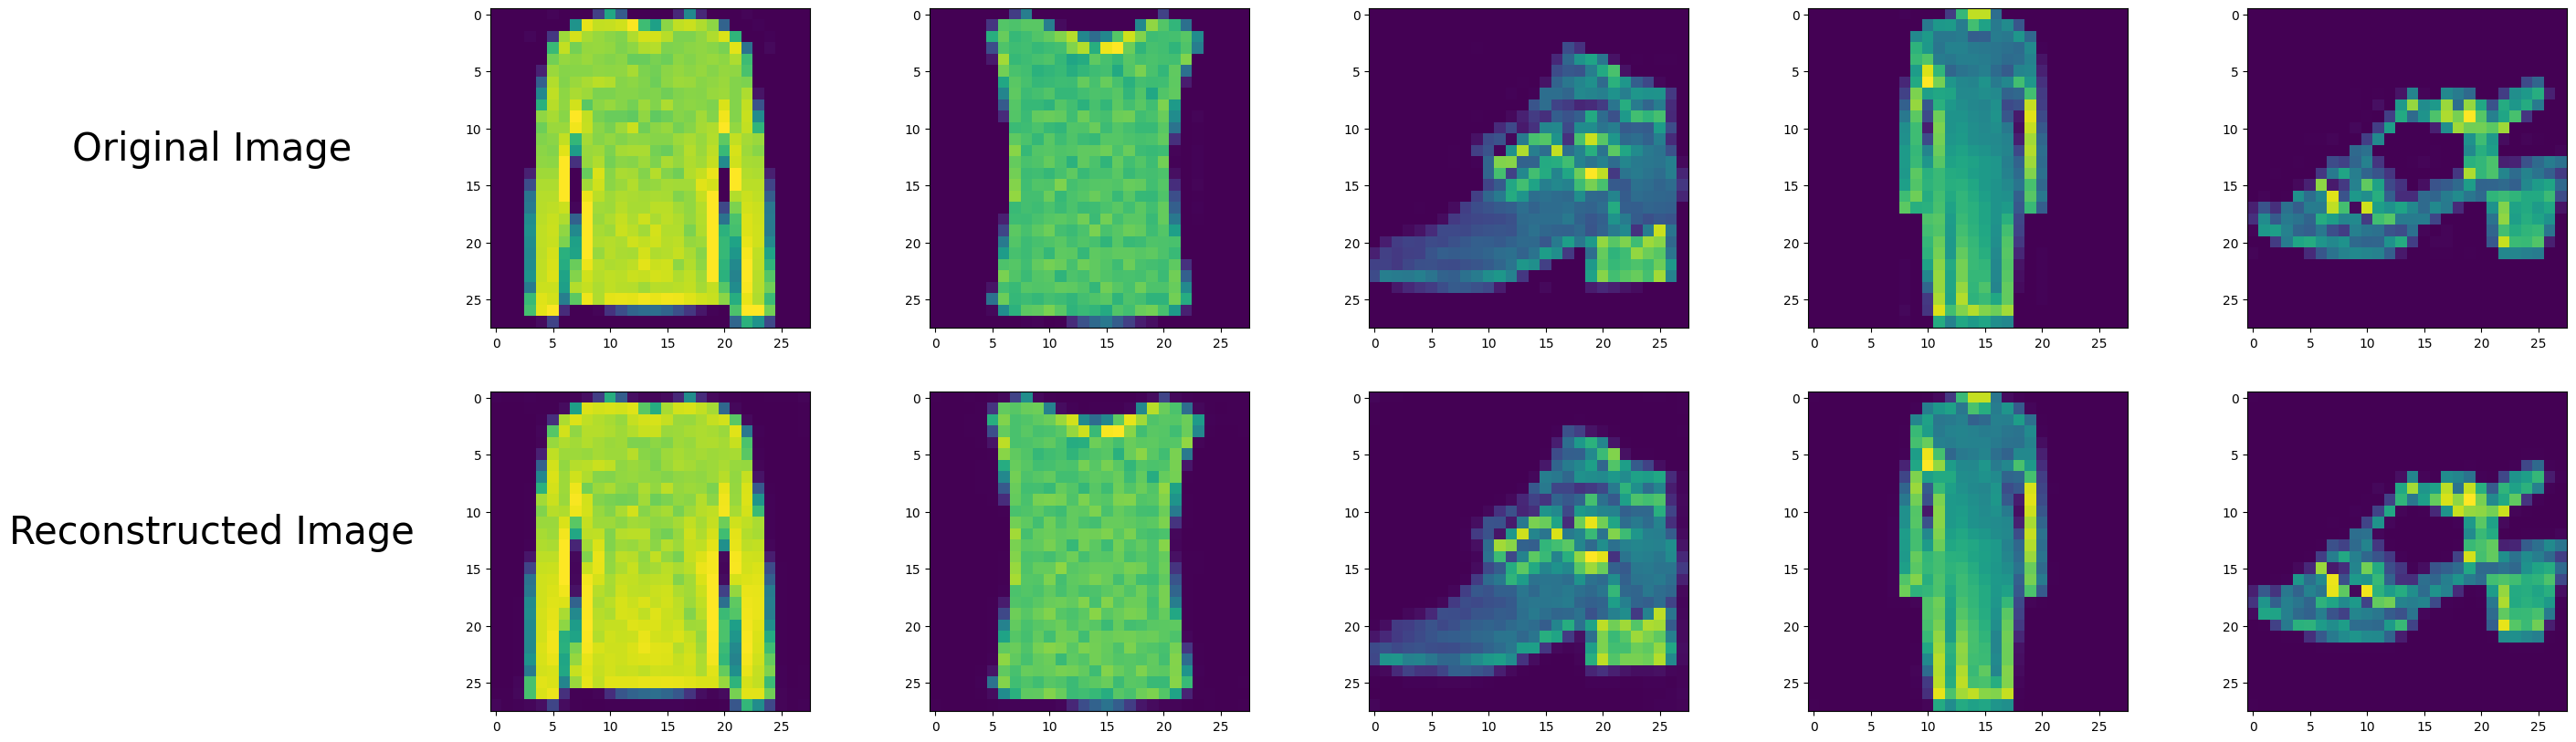

In [ ]:
fig, ax = plt.subplots(2, 5, figsize = (30, 10))
for i in range(5):
  ax[0, i].imshow(outputs[i][0][i].cpu().detach().numpy().reshape(28, 28))
  fig.axes[0].set_ylabel('Original Image', rotation = 0, fontsize = 30, labelpad = 200)
  ax[1, i].imshow(outputs[i][1][i].cpu().detach().numpy().reshape(28, 28))
  fig.axes[5].set_ylabel('Reconstructed Image', rotation = 0, fontsize = 30, labelpad = 200)

### Word Embeddings

In [ ]:
word_to_ix = {"hello": 0, "world": 1}

In [ ]:
para = '''
There was nothing so very remarkable in that;
nor did Alice think it so very much out of the way
 to hear the Rabbit say to itself,
 “Oh dear! Oh dear! I shall be late!”
 (when she thought it over afterwards,
 it occurred to her that she ought to have wondered at this,
 but at the time it all seemed quite natural);
 but when the Rabbit actually took a watch out
 of its waistcoat-pocket, and looked at it, and then hurried on,
 Alice started to her feet, for it flashed across her mind
 that she had never before seen a rabbit with either a waistcoat-pocket,
 or a watch to take out of it, and burning with curiosity,
 she ran across the field after it,
 and fortunately was just in time to see it pop down a large rabbit-hole under the hedge.
'''.split()

In [ ]:
para[:10]

['There',
 'was',
 'nothing',
 'so',
 'very',
 'remarkable',
 'in',
 'that;',
 'nor',
 'did']

In [ ]:
#create data structure
ngrams = [([para[i - j - 1] for j in range(3)], para[i]) for i in range(2, len(para))]

In [ ]:
#examine first few
ngrams[:4]

[(['was', 'There', 'hedge.'], 'nothing'),
 (['nothing', 'was', 'There'], 'so'),
 (['so', 'nothing', 'was'], 'very'),
 (['very', 'so', 'nothing'], 'remarkable')]

In [ ]:
#create the vocabulary
vocab = set(para)

In [ ]:
#words to indicies
word_to_idx = {word:i for i,word in enumerate(vocab)}

In [ ]:
#examine first few
list(word_to_idx.items())[:5]

[('she', 0), ('field', 1), ('nor', 2), ('burning', 3), ('say', 4)]

In [ ]:
#create NGramLanguageModeler
class NGramLanguageModeler(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_size):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.linear1 = nn.Linear(context_size*embedding_dim, 128)
    self.linear2 = nn.Linear(128, vocab_size)

  def forward(self, inputs):
    embeds = self.embeddings(inputs).view(1, -1)
    x = F.relu(self.linear1(embeds))
    x = F.log_softmax(self.linear2(x))
    return x

In [ ]:
#loss
loss_fn = nn.NLLLoss()

In [ ]:
#optimizer
model = NGramLanguageModeler(len(vocab), 5, 3)
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
ngrams[0]

(['was', 'There', 'hedge.'], 'nothing')

In [ ]:
[word_to_idx[i] for i in ngrams[0][0]]

[27, 66, 52]

In [ ]:
losses = []
for epoch in range(20):
  total_loss = 0
  for context, target in ngrams:
    #context vector
    context_idxs = torch.tensor([word_to_idx[i] for i in context], dtype = torch.long)
    #pass through model
    log_probs = model(context_idxs)
    #evaluate loss
    loss = loss_fn(log_probs, torch.tensor([word_to_idx[target]], dtype = torch.long))
    #gradient, backprop, step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()


  losses.append(total_loss)

<ipython-input-30-87c3324535f7>:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.linear2(x))


In [ ]:
#examine word weights
print(model.embeddings.weight[word_to_idx["Alice"]])

tensor([ 0.2768,  1.1927, -0.3504,  2.4711,  0.3954],
       grad_fn=<SelectBackward0>)


### Pretrained Models

In [ ]:
pip install transformers datasets evaluate spacy

In [ ]:
import spacy

In [ ]:
!python -m spacy download en_core_web_lg

2024-01-30 18:21:18.042542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 18:21:18.042654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 18:21:18.044023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 18:21:19.386145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
sentence = "This is a sentence with stuff"

In [ ]:
doc = nlp(sentence)

In [ ]:
for token in doc:
  print(token.text, token.pos_)

This PRON
is AUX
a DET
sentence NOUN
with ADP
stuff NOUN


In [ ]:
this = doc[0]

In [ ]:
this.vector

#### Tokenizer

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
tokenizer("This is serious stuff.")

{'input_ids': [101, 1188, 1110, 3021, 4333, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
from datasets import load_dataset
dataset = load_dataset("yelp_review_full")

In [ ]:
dataset['train'][0]

{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [ ]:
def tokenized_fn(ex):
  return tokenizer(ex['text'], truncation = True)

In [ ]:
tokenized_datasets = dataset.map(tokenized_fn, batched = True)

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Training the model

In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Training Arguments

In [ ]:
from transformers import TrainingArguments

In [ ]:
training_args = TrainingArguments(output_dir = '.' )

#### Evaluation Metrics

In [ ]:
import numpy as np
import evaluate

In [ ]:
metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis = -1)
  return metric.compute(predictions = predictions, references = labels)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
tokenized_datasets.keys()

dict_keys(['train', 'test'])

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.226400
1000,1.063600
1500,1.039300
2000,1.014000
2500,1.012400
3000,0.957300
3500,0.966100
4000,0.970000
4500,0.966100
5000,0.957600


#### Next Steps

- Sequence to Sequence models with `pytorch`: [tutorial]()
- Sequence to Sequence models with `transformers`: [tutorial](https://colab.research.google.com/drive/1xwnJoCa1dt9n-fIGx49uj-OSuLgFsGYn?usp=sharing)
